In [1]:
# Importar bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from tqdm import tqdm
import plotly.express as px

# Configurar visualizações
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Bibliotecas importadas com sucesso!")
print(f"Pandas version: {pd.__version__}")
print(f"NetworkX version: {nx.__version__}")


Bibliotecas importadas com sucesso!
Pandas version: 2.3.3
NetworkX version: 3.5


In [2]:
# Explorar os dados disponíveis
import os

database_path = 'database/'
files = os.listdir(database_path)

print("Arquivos disponíveis:")
for file in files:
    if file.endswith('.csv'):
        file_path = os.path.join(database_path, file)
        size = os.path.getsize(file_path)
        print(f"- {file} ({size:,} bytes)")


Arquivos disponíveis:
- openalex_authors.csv (81,467,657 bytes)
- openalex_citations.csv (1,234,593,392 bytes)
- openalex_concepts.csv (1,269,477,051 bytes)
- openalex_keywords.csv (119,325,710 bytes)
- openalex_progress_report.csv (9,942 bytes)
- openalex_related_works.csv (540,386,788 bytes)
- openalex_topics.csv (214,365,704 bytes)
- openalex_works.csv (726,785,683 bytes)


In [3]:
# Carregar dados de autores
print("Carregando dados de autores...")
authors_df = pd.read_csv('database/openalex_authors.csv')
print(f"Total de registros: {len(authors_df):,}")
print(f"Total de trabalhos únicos: {authors_df['work_id'].nunique():,}")
print(f"Total de autores únicos: {authors_df['author_id'].nunique():,}")
print("\nPrimeiras linhas:")
print(authors_df.head())


Carregando dados de autores...
Total de registros: 824,552
Total de trabalhos únicos: 771,134
Total de autores únicos: 8,469

Primeiras linhas:
                            work_id                         author_id  \
0  https://openalex.org/W4283756975  https://openalex.org/A5091083068   
1  https://openalex.org/W2946474052  https://openalex.org/A5091083068   
2  https://openalex.org/W3158895417  https://openalex.org/A5091083068   
3  https://openalex.org/W2339776436  https://openalex.org/A5028316834   
4  https://openalex.org/W4399913519  https://openalex.org/A5028316834   

              author_name author_position  is_corresponding countries  
0  Marcelo Garcia Manzato            last             False        BR  
1  Marcelo Garcia Manzato          middle             False        BR  
2  Marcelo Garcia Manzato          middle             False        BR  
3           Rodrigo Souza            last             False        BR  
4           Rodrigo Souza          middle             Fal

In [5]:
# Construir grafo de coautoria
# Para cada trabalho, criar arestas entre todos os pares de autores
print("Construindo grafo de coautoria...")

# Criar grafo não direcionado
G = nx.Graph()

# Agrupar por work_id e criar arestas entre coautores
for work_id, group in tqdm(authors_df.groupby('work_id'), desc="Processando trabalhos"):
    author_ids = group['author_id'].unique()
    # Criar arestas entre todos os pares de autores do mesmo trabalho
    for i, author1 in enumerate(author_ids):
        for author2 in author_ids[i+1:]:
            if G.has_edge(author1, author2):
                # Incrementar peso da aresta (número de trabalhos em conjunto)
                G[author1][author2]['weight'] += 1
            else:
                G.add_edge(author1, author2, weight=1)

print(f"\nGrafo construído:")
print(f"- Número de nós (autores): {G.number_of_nodes():,}")
print(f"- Número de arestas (coautorias): {G.number_of_edges():,}")
print(f"- Densidade: {nx.density(G):.6f}")


Construindo grafo de coautoria...


Processando trabalhos: 100%|██████████| 771134/771134 [01:29<00:00, 8610.69it/s]



Grafo construído:
- Número de nós (autores): 4,229
- Número de arestas (coautorias): 6,682
- Densidade: 0.000747


In [6]:
# Classe para predição de links de coautoria
class CoauthorshipLinkPredictor:
    """
    Classe para predição de links de coautoria baseada em distância 2.
    Recomenda autores que são coautores dos coautores do autor alvo.
    """
    
    def __init__(self, graph):
        """
        Inicializa o preditor com um grafo de coautoria.
        
        Args:
            graph: NetworkX Graph com autores como nós e coautorias como arestas
        """
        self.graph = graph
        self.author_to_name = {}
        self._build_author_names()
    
    def _build_author_names(self):
        """Constrói mapeamento de author_id para author_name"""
        unique_authors = authors_df[['author_id', 'author_name']].drop_duplicates()
        self.author_to_name = dict(zip(unique_authors['author_id'], unique_authors['author_name']))
    
    def get_recommendations(self, author_id, top_k=None):
        """
        Obtém recomendações de coautoria para um autor baseado em distância 2.
        
        Args:
            author_id: ID do autor para o qual fazer recomendações
            top_k: Número máximo de recomendações a retornar (None = todas)
        
        Returns:
            Lista de tuplas (author_id, score) ordenada por score decrescente
        """
        if author_id not in self.graph:
            return []
        
        # Obter coautores diretos (distância 1)
        direct_coauthors = set(self.graph.neighbors(author_id))
        
        # Contar quantas vezes cada autor aparece como coautor de coautores
        recommendation_scores = {}
        
        for coauthor in direct_coauthors:
            # Obter coautores do coautor (distância 2 do autor original)
            for potential_coauthor in self.graph.neighbors(coauthor):
                # Ignorar o próprio autor e seus coautores diretos
                if potential_coauthor != author_id and potential_coauthor not in direct_coauthors:
                    # Score baseado no número de caminhos de distância 2
                    if potential_coauthor not in recommendation_scores:
                        recommendation_scores[potential_coauthor] = 0
                    recommendation_scores[potential_coauthor] += 1
        
        # Ordenar por score
        recommendations = sorted(recommendation_scores.items(), key=lambda x: x[1], reverse=True)
        
        if top_k:
            recommendations = recommendations[:top_k]
        
        return recommendations
    
    def get_recommendations_with_names(self, author_id, top_k=None):
        """
        Obtém recomendações com nomes dos autores.
        
        Args:
            author_id: ID do autor
            top_k: Número máximo de recomendações
        
        Returns:
            Lista de dicionários com author_id, author_name e score
        """
        recommendations = self.get_recommendations(author_id, top_k)
        result = []
        for author_id_rec, score in recommendations:
            result.append({
                'author_id': author_id_rec,
                'author_name': self.author_to_name.get(author_id_rec, 'Unknown'),
                'score': score
            })
        return result

# Testar a classe
predictor = CoauthorshipLinkPredictor(G)
print("Classe CoauthorshipLinkPredictor criada com sucesso!")


Classe CoauthorshipLinkPredictor criada com sucesso!


In [7]:
# Testar recomendações para um autor exemplo
# Pegar um autor que tenha coautores
sample_author = None
for node in G.nodes():
    if G.degree(node) > 0:
        sample_author = node
        break

if sample_author:
    author_name = authors_df[authors_df['author_id'] == sample_author]['author_name'].iloc[0]
    print(f"Testando recomendações para: {author_name} ({sample_author})")
    print(f"Coautores diretos: {G.degree(sample_author)}")
    
    recommendations = predictor.get_recommendations_with_names(sample_author, top_k=10)
    print(f"\nTop 10 recomendações:")
    for i, rec in enumerate(recommendations, 1):
        print(f"{i}. {rec['author_name']} (score: {rec['score']})")


Testando recomendações para: Saglara Mandzhieva (https://openalex.org/A5011589516)
Coautores diretos: 3

Top 10 recomendações:


In [8]:
# Classe para avaliação do modelo
from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score
from collections import defaultdict
import random

class CoauthorshipEvaluator:
    """
    Classe para avaliar o modelo de predição de links de coautoria.
    Separa dados em treino/teste (80/20) e calcula métricas.
    """
    
    def __init__(self, graph, test_size=0.2, random_state=42):
        """
        Inicializa o avaliador.
        
        Args:
            graph: NetworkX Graph completo
            test_size: Proporção de arestas para teste (default: 0.2)
            random_state: Seed para reprodutibilidade
        """
        self.full_graph = graph
        self.test_size = test_size
        self.random_state = random_state
        self.train_graph = None
        self.test_edges = None
        self.test_non_edges = None
        self.predictor = None
        
    def split_data(self):
        """
        Separa o grafo em treino (80%) e teste (20%).
        Remove 20% das arestas para teste e mantém 80% para treino.
        """
        print("Separando dados em treino e teste...")
        
        # Obter todas as arestas
        all_edges = list(self.full_graph.edges())
        random.seed(self.random_state)
        random.shuffle(all_edges)
        
        # Separar 80/20
        split_idx = int(len(all_edges) * (1 - self.test_size))
        train_edges = all_edges[:split_idx]
        test_edges = all_edges[split_idx:]
        
        # Criar grafo de treino
        self.train_graph = nx.Graph()
        self.train_graph.add_edges_from(train_edges)
        
        # Adicionar todos os nós (mesmo que não tenham arestas no treino)
        self.train_graph.add_nodes_from(self.full_graph.nodes())
        
        # Criar preditor com grafo de treino
        self.predictor = CoauthorshipLinkPredictor(self.train_graph)
        
        # Arestas de teste (links positivos)
        self.test_edges = set(test_edges)
        
        # Gerar arestas negativas (pares de autores que não têm link)
        # Usar amostragem para não gerar todas as possíveis combinações
        print("Gerando arestas negativas para teste...")
        all_nodes = list(self.full_graph.nodes())
        num_negative = len(test_edges)
        
        negative_edges = set()
        max_attempts = num_negative * 10
        attempts = 0
        
        while len(negative_edges) < num_negative and attempts < max_attempts:
            node1, node2 = random.sample(all_nodes, 2)
            # Verificar se não existe aresta no grafo completo
            if not self.full_graph.has_edge(node1, node2):
                negative_edges.add((node1, node2))
            attempts += 1
        
        self.test_non_edges = list(negative_edges)
        
        print(f"Grafo de treino: {self.train_graph.number_of_nodes()} nós, {self.train_graph.number_of_edges()} arestas")
        print(f"Arestas de teste (positivas): {len(self.test_edges)}")
        print(f"Arestas de teste (negativas): {len(self.test_non_edges)}")
    
    def evaluate(self, top_k=10):
        """
        Avalia o modelo calculando precisão, acurácia e F1-score.
        
        Args:
            top_k: Número de recomendações a considerar para cada autor
        
        Returns:
            Dicionário com métricas
        """
        if self.train_graph is None:
            self.split_data()
        
        print(f"\nAvaliando modelo (top_k={top_k})...")
        
        # Para cada autor, obter recomendações e verificar se estão no conjunto de teste
        true_positives = 0
        false_positives = 0
        false_negatives = 0
        true_negatives = 0
        
        # Processar arestas positivas de teste
        for author1, author2 in tqdm(self.test_edges, desc="Avaliando arestas positivas"):
            if author1 in self.train_graph and self.train_graph.degree(author1) > 0:
                recommendations = self.predictor.get_recommendations(author1, top_k=top_k)
                recommended_authors = {rec[0] for rec in recommendations}
                
                if author2 in recommended_authors:
                    true_positives += 1
                else:
                    false_negatives += 1
            else:
                false_negatives += 1
        
        # Processar arestas negativas de teste
        for author1, author2 in tqdm(self.test_non_edges, desc="Avaliando arestas negativas"):
            if author1 in self.train_graph and self.train_graph.degree(author1) > 0:
                recommendations = self.predictor.get_recommendations(author1, top_k=top_k)
                recommended_authors = {rec[0] for rec in recommendations}
                
                if author2 in recommended_authors:
                    false_positives += 1
                else:
                    true_negatives += 1
            else:
                true_negatives += 1
        
        # Calcular métricas
        total = true_positives + false_positives + false_negatives + true_negatives
        
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        accuracy = (true_positives + true_negatives) / total if total > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        metrics = {
            'precision': precision,
            'recall': recall,
            'accuracy': accuracy,
            'f1_score': f1,
            'true_positives': true_positives,
            'false_positives': false_positives,
            'false_negatives': false_negatives,
            'true_negatives': true_negatives,
            'total': total
        }
        
        return metrics
    
    def print_metrics(self, metrics):
        """Imprime métricas de forma formatada"""
        print("\n" + "="*50)
        print("MÉTRICAS DE AVALIAÇÃO")
        print("="*50)
        print(f"Precisão (Precision): {metrics['precision']:.4f}")
        print(f"Revocação (Recall):   {metrics['recall']:.4f}")
        print(f"Acurácia (Accuracy):  {metrics['accuracy']:.4f}")
        print(f"F1-Score:             {metrics['f1_score']:.4f}")
        print("\nMatriz de Confusão:")
        print(f"  Verdadeiros Positivos:  {metrics['true_positives']:,}")
        print(f"  Falsos Positivos:       {metrics['false_positives']:,}")
        print(f"  Falsos Negativos:       {metrics['false_negatives']:,}")
        print(f"  Verdadeiros Negativos:  {metrics['true_negatives']:,}")
        print(f"  Total:                  {metrics['total']:,}")
        print("="*50)

print("Classe CoauthorshipEvaluator criada com sucesso!")


Classe CoauthorshipEvaluator criada com sucesso!


In [9]:
# Executar avaliação do modelo
evaluator = CoauthorshipEvaluator(G, test_size=0.2, random_state=42)
metrics = evaluator.evaluate(top_k=10)
evaluator.print_metrics(metrics)


Separando dados em treino e teste...
Gerando arestas negativas para teste...
Grafo de treino: 4229 nós, 5345 arestas
Arestas de teste (positivas): 1337
Arestas de teste (negativas): 1337

Avaliando modelo (top_k=10)...


Avaliando arestas negativas: 100%|██████████| 1337/1337 [00:00<00:00, 96512.88it/s]


MÉTRICAS DE AVALIAÇÃO
Precisão (Precision): 1.0000
Revocação (Recall):   0.7375
Acurácia (Accuracy):  0.8687
F1-Score:             0.8489

Matriz de Confusão:
  Verdadeiros Positivos:  986
  Falsos Positivos:       0
  Falsos Negativos:       351
  Verdadeiros Negativos:  1,337
  Total:                  2,674


In [10]:
# Testar com diferentes valores de top_k
print("Avaliando modelo com diferentes valores de top_k...\n")

results = []
for top_k in [5, 10, 20, 50]:
    print(f"\nAvaliando com top_k={top_k}...")
    evaluator_k = CoauthorshipEvaluator(G, test_size=0.2, random_state=42)
    metrics_k = evaluator_k.evaluate(top_k=top_k)
    metrics_k['top_k'] = top_k
    results.append(metrics_k)
    evaluator_k.print_metrics(metrics_k)

# Criar DataFrame com resultados
results_df = pd.DataFrame(results)
print("\n" + "="*60)
print("RESUMO DOS RESULTADOS")
print("="*60)
print(results_df[['top_k', 'precision', 'recall', 'accuracy', 'f1_score']].to_string(index=False))


Avaliando modelo com diferentes valores de top_k...


Avaliando com top_k=5...
Separando dados em treino e teste...
Gerando arestas negativas para teste...
Grafo de treino: 4229 nós, 5345 arestas
Arestas de teste (positivas): 1337
Arestas de teste (negativas): 1337

Avaliando modelo (top_k=5)...


Avaliando arestas negativas: 100%|██████████| 1337/1337 [00:00<00:00, 112669.46it/s]


MÉTRICAS DE AVALIAÇÃO
Precisão (Precision): 1.0000
Revocação (Recall):   0.6889
Acurácia (Accuracy):  0.8444
F1-Score:             0.8158

Matriz de Confusão:
  Verdadeiros Positivos:  921
  Falsos Positivos:       0
  Falsos Negativos:       416
  Verdadeiros Negativos:  1,337
  Total:                  2,674

Avaliando com top_k=10...
Separando dados em treino e teste...


Gerando arestas negativas para teste...
Grafo de treino: 4229 nós, 5345 arestas
Arestas de teste (positivas): 1337
Arestas de teste (negativas): 1337

Avaliando modelo (top_k=10)...


Avaliando arestas negativas: 100%|██████████| 1337/1337 [00:00<00:00, 129435.30it/s]


MÉTRICAS DE AVALIAÇÃO
Precisão (Precision): 1.0000
Revocação (Recall):   0.7375
Acurácia (Accuracy):  0.8687
F1-Score:             0.8489

Matriz de Confusão:
  Verdadeiros Positivos:  986
  Falsos Positivos:       0
  Falsos Negativos:       351
  Verdadeiros Negativos:  1,337
  Total:                  2,674

Avaliando com top_k=20...
Separando dados em treino e teste...


Gerando arestas negativas para teste...
Grafo de treino: 4229 nós, 5345 arestas
Arestas de teste (positivas): 1337
Arestas de teste (negativas): 1337

Avaliando modelo (top_k=20)...


Avaliando arestas negativas: 100%|██████████| 1337/1337 [00:00<00:00, 135972.66it/s]


MÉTRICAS DE AVALIAÇÃO
Precisão (Precision): 1.0000
Revocação (Recall):   0.7405
Acurácia (Accuracy):  0.8702
F1-Score:             0.8509

Matriz de Confusão:
  Verdadeiros Positivos:  990
  Falsos Positivos:       0
  Falsos Negativos:       347
  Verdadeiros Negativos:  1,337
  Total:                  2,674

Avaliando com top_k=50...
Separando dados em treino e teste...


Gerando arestas negativas para teste...
Grafo de treino: 4229 nós, 5345 arestas
Arestas de teste (positivas): 1337
Arestas de teste (negativas): 1337

Avaliando modelo (top_k=50)...


Avaliando arestas negativas: 100%|██████████| 1337/1337 [00:00<00:00, 132327.73it/s]


MÉTRICAS DE AVALIAÇÃO
Precisão (Precision): 1.0000
Revocação (Recall):   0.7427
Acurácia (Accuracy):  0.8714
F1-Score:             0.8524

Matriz de Confusão:
  Verdadeiros Positivos:  993
  Falsos Positivos:       0
  Falsos Negativos:       344
  Verdadeiros Negativos:  1,337
  Total:                  2,674

RESUMO DOS RESULTADOS
 top_k  precision   recall  accuracy  f1_score
     5        1.0 0.688856  0.844428  0.815766
    10        1.0 0.737472  0.868736  0.848902
    20        1.0 0.740464  0.870232  0.850881
    50        1.0 0.742708  0.871354  0.852361


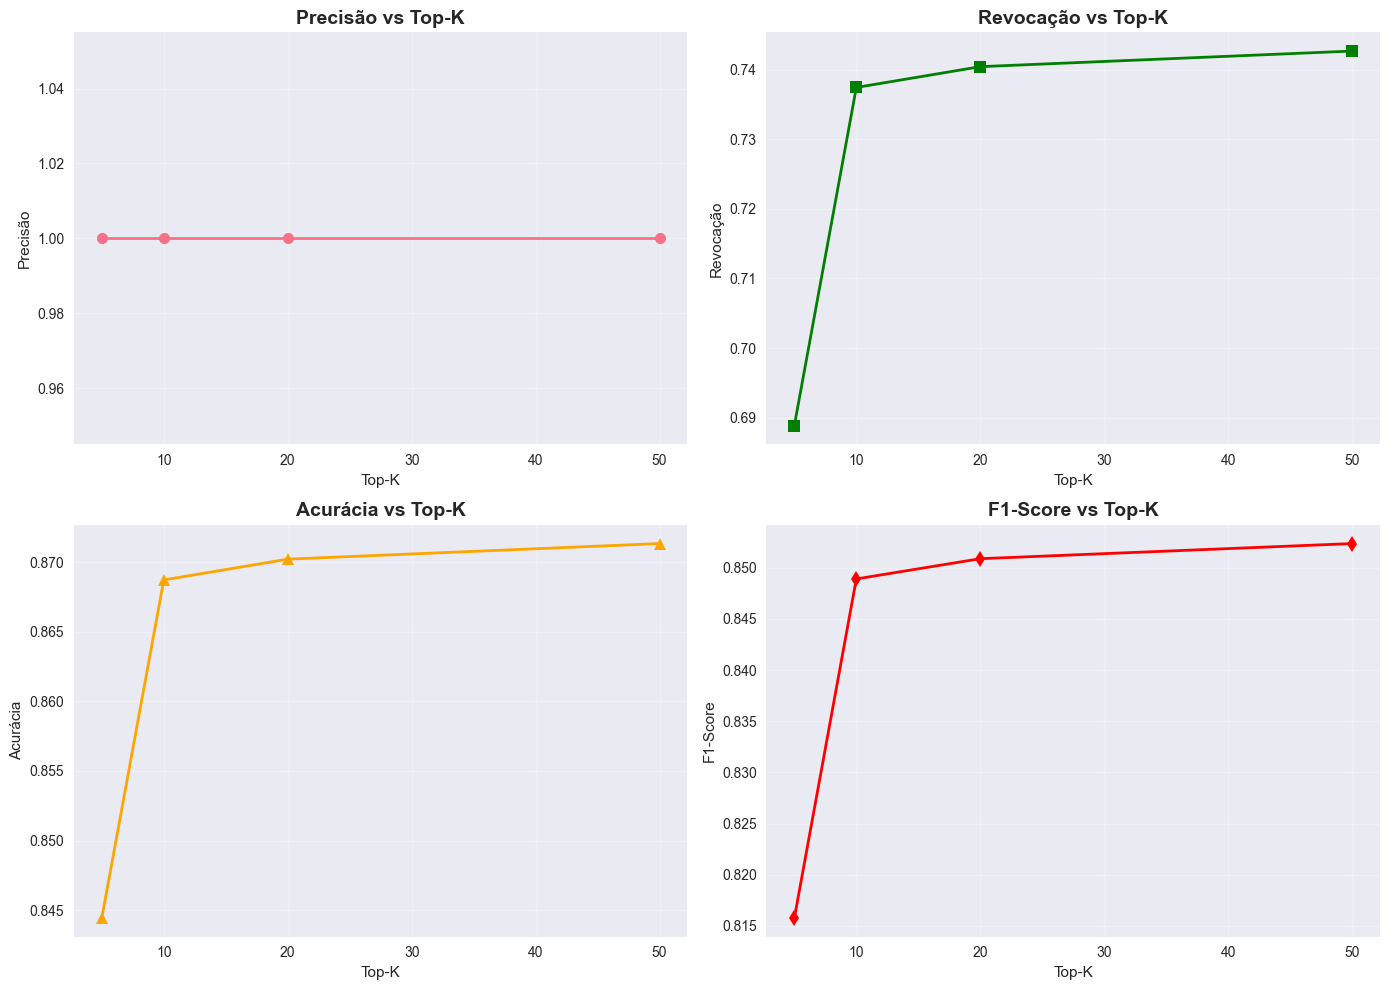

In [11]:
# Visualizar resultados
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(results_df['top_k'], results_df['precision'], marker='o', linewidth=2, markersize=8)
axes[0, 0].set_title('Precisão vs Top-K', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Top-K')
axes[0, 0].set_ylabel('Precisão')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(results_df['top_k'], results_df['recall'], marker='s', color='green', linewidth=2, markersize=8)
axes[0, 1].set_title('Revocação vs Top-K', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Top-K')
axes[0, 1].set_ylabel('Revocação')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(results_df['top_k'], results_df['accuracy'], marker='^', color='orange', linewidth=2, markersize=8)
axes[1, 0].set_title('Acurácia vs Top-K', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Top-K')
axes[1, 0].set_ylabel('Acurácia')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(results_df['top_k'], results_df['f1_score'], marker='d', color='red', linewidth=2, markersize=8)
axes[1, 1].set_title('F1-Score vs Top-K', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Top-K')
axes[1, 1].set_ylabel('F1-Score')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
